In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [55]:
# Import necessary libraries and make necessary arrangements
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost 
import lightgbm as lgb
import warnings
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [56]:

# Date Features
def create_date_features(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    #df["is_wknd"] = df.Date.dt.weekday // 4
    #df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    #df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df

# Random Noise
def random_noise(dataframe):
    return np.random.normal(scale=2.0, size=(len(dataframe),))

# Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        

In [57]:
df_train=pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\train.csv",index_col=0)
df_test =pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\test.csv",index_col=0)
df_transactions = pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\transactions.csv")
df_stores = pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\stores.csv")
df_holidays = pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\holidays_events.csv")

df_oil = pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\oil.csv")
df_oil['date'] = df_oil['date'].astype("datetime64")
df_date = pd.DataFrame(pd.date_range("2013-01-01","2017-08-31"),columns=["date"])
df_oil = df_date.merge(df_oil,left_on='date',right_on='date',how='left').fillna(method='ffill').fillna(method='bfill')

In [58]:
df_all = df_train.append(df_test)
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")
df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")
df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],right_on=["date","store_nbr"],how="left")
df_all["date"] = df_all["date"].astype("datetime64")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace(",","_",regex=True)
df_all = df_all.rename(columns = {"date":"Date"})

In [59]:
# df_all["family"].unique()

In [60]:
#df_all.columns

In [61]:
# df_all["description"].nunique(),df_all["transferred"].nunique()

In [62]:
#df_all[(df_all["store_nbr"]==9) & (df_all["family"]=="AUTOMOTIVE")].tail(10)

In [63]:
col = ['Date',
       'store_nbr', 
       'family', 
       'sales', 
       'onpromotion', 
       #'city', 
       #'state',
       #'type', 
       'cluster', 
       'Holiday_type', 
       'locale', 
       #'locale_name',
       'description', 
       'transferred',
       'dcoilwtico'
      ]
df = df_all[col]

In [64]:
df.head()

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14


In [65]:
#df["store_nbr"].nunique(),df["family"].nunique()

In [66]:
df.loc[:,"store_nbr"] = df["store_nbr"].astype("category")
df.loc[:,"family"] = df["family"].astype("category")
df.loc[:,"onpromotion"] = df["onpromotion"].astype("int64")
#df.loc[:,"city"] = df["city"].astype("category")
#df.loc[:,"state"] = df["state"].astype("category")
#df.loc[:,"type"] = df["type"].astype("category")
df.loc[:,"Holiday_type"] = df["Holiday_type"].astype("category")
df.loc[:,"locale"] = df["locale"].astype("category")
#df.loc[:,"locale_name"] = df["locale_name"].astype("category")
df.loc[:,"description"] = df["description"].astype("category")
df.loc[:,"transferred"] = df["transferred"].astype("category")

In [67]:
zero_index = df.groupby(["store_nbr","family"]).sum()[df.groupby(["store_nbr","family"]).sum()["sales"]==0].index

## Data Engineering

In [68]:
df = create_date_features(df)
df

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,9,POULTRY,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017
3082856,2017-08-31,9,PREPARED FOODS,NaN,0,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017
3082857,2017-08-31,9,PRODUCE,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017
3082858,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017


In [69]:
df = lag_features(df, lags = [16,17,18,19,20,21,22,30,31,90,180,365])
df

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_30,sales_lag_31,sales_lag_90,sales_lag_180,sales_lag_365
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,9,POULTRY,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,435.755473,282.505360,413.782082,384.115154,525.528939,290.796086,332.678810,566.281279,473.214692,551.353420,283.269116,416.741037
3082856,2017-08-31,9,PREPARED FOODS,NaN,0,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,156.486040,113.868494,108.953551,127.234476,112.136607,110.659742,121.020592,50.946707,60.034310,76.312500,92.841726,130.432708
3082857,2017-08-31,9,PRODUCE,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,2421.221216,1347.222555,1695.463557,1415.734929,1454.047609,1033.642038,1308.517105,2471.012492,1514.452487,1688.925054,1148.455425,1353.662611
3082858,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,117.857629,180.622164,199.154060,135.884946,141.753131,150.523136,83.966247,205.411060,51.792784,7.512636,7.967606,82.581263


In [70]:
df = roll_mean_features(df,[16,17,18,30])
df

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_30,sales_lag_31,sales_lag_90,sales_lag_180,sales_lag_365,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,9,POULTRY,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,435.755473,282.505360,413.782082,384.115154,525.528939,290.796086,332.678810,566.281279,473.214692,551.353420,283.269116,416.741037,446.344824,455.151733,463.022243,447.437564
3082856,2017-08-31,9,PREPARED FOODS,NaN,0,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,156.486040,113.868494,108.953551,127.234476,112.136607,110.659742,121.020592,50.946707,60.034310,76.312500,92.841726,130.432708,123.633441,117.074557,119.599022,105.591766
3082857,2017-08-31,9,PRODUCE,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,2421.221216,1347.222555,1695.463557,1415.734929,1454.047609,1033.642038,1308.517105,2471.012492,1514.452487,1688.925054,1148.455425,1353.662611,1628.660925,1642.209551,1643.485618,1610.016995
3082858,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,117.857629,180.622164,199.154060,135.884946,141.753131,150.523136,83.966247,205.411060,51.792784,7.512636,7.967606,82.581263,150.112376,147.977350,145.721588,84.202358


In [71]:
alphas = [0.95,0.9, 0.8, 0.5]
lags =[1, 7,30]
df = ewm_features(df, alphas, lags)
df

,Date,store_nbr,family,sales,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,year,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_30,sales_lag_31,sales_lag_90,sales_lag_180,sales_lag_365,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,93.14,1,1,1,1,1,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082855,2017-08-31,9,POULTRY,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,435.755473,282.505360,413.782082,384.115154,525.528939,290.796086,332.678810,566.281279,473.214692,551.353420,283.269116,416.741037,446.344824,455.151733,463.022243,447.437564,430.717553,430.717553,565.318991,423.935714,423.935714,560.611289,412.276337,412.276337,551.421713,392.438031,392.438031,518.514476
3082856,2017-08-31,9,PREPARED FOODS,NaN,0,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,156.486040,113.868494,108.953551,127.234476,112.136607,110.659742,121.020592,50.946707,60.034310,76.312500,92.841726,130.432708,123.633441,117.074557,119.599022,105.591766,152.511953,152.511953,51.246066,150.443153,150.443153,52.444705,146.278339,146.278339,56.022566,134.243896,134.243896,72.911551
3082857,2017-08-31,9,PRODUCE,NaN,1,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,2421.221216,1347.222555,1695.463557,1415.734929,1454.047609,1033.642038,1308.517105,2471.012492,1514.452487,1688.925054,1148.455425,1353.662611,1628.660925,1642.209551,1643.485618,1610.016995,2366.992548,2366.992548,2423.706728,2315.775659,2315.775659,2378.620204,2217.030205,2217.030205,2292.418673,1934.923106,1934.923106,2035.920473
3082858,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,6,NaN,NaN,NaN,NaN,47.26,8,31,243,35,3,2017,117.857629,180.622164,199.154060,135.884946,141.753131,150.523136,83.966247,205.411060,51.792784,7.512636,7.967606,82.581263,150.112376,147.977350,145.721588,84.202358,124.087264,124.087264,195.609900,127.218224,127.218224,188.128407,133.426673,133.426673,172.814546,148.242507,148.242507,122.237914


In [15]:
df['sales'] = np.log1p(df["sales"].values)

In [16]:
df_all["family"]=df_all["family"].astype("category")
df_all["store_nbr"]=df_all["store_nbr"].astype("category")
df_all["city"]=df_all["city"].astype("category")
df_all["state"]=df_all["state"].astype("category")
df_all["type"]=df_all["type"].astype("category")

## Train Test Split

In [17]:
df= df[df["Date"]>"2013-12-31"]

val = df[(df["Date"]>"2017-08-01")&(df["Date"]<="2017-08-15")]
train  = df[df["Date"]<="2017-08-01"]
test = df[df["Date"]>"2017-08-15"]

col_X = [col for col in train.columns if col not in ['Date', 'sales','year']]

y_train = train["sales"]
y_val = val["sales"]
X_train = train[col_X]
X_val = val[col_X]
X_test = test[col_X]
y_test = test["sales"]

## Train Model

In [18]:
# LightGBM parameters
lgb_params = {'metric': {'mse'},
              'boosting_type' : 'gbdt',
              'num_leaves': 8,
              'learning_rate': 0.2,
              #'feature_fraction': 0.8,
              'max_depth': 7,
              'verbose': 0,
              'num_boost_round': 5000,
              'early_stopping_rounds': 200,
              'nthread': -1,
             'force_col_wise':True}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=col_X)
lgbtest = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=col_X)

#del Y_train, X_train, Y_test,X_test

In [48]:
X_train[X_train.index == 1717309]

,store_nbr,family,onpromotion,cluster,Holiday_type,locale,description,transferred,dcoilwtico,month,day_of_month,day_of_year,week_of_year,day_of_week,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20,sales_lag_21,sales_lag_22,sales_lag_30,sales_lag_31,sales_lag_90,sales_lag_180,sales_lag_365,sales_roll_mean_16,sales_roll_mean_17,sales_roll_mean_18,sales_roll_mean_30,sales_ewm_alpha_095_lag_1,sales_ewm_alpha_095_lag_7,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
1717309,43,LIQUOR_WINE_BEER,0,10,Holiday,National,Primer Grito de Independencia,False,44.94,8,10,222,33,0,221.087422,46.859708,229.401381,37.173036,13.496806,128.052247,-0.995154,116.815625,76.395291,89.227706,475.869777,26.342446,57.471186,60.005781,54.276848,79.970769,10.809777,219.746729,116.866547,21.73718,209.114819,114.382363,43.43461,189.780855,108.586911,101.436902,144.961749,94.086287


In [36]:
y_train

657558     0.000000
657559     0.000000
657560     0.000000
657561     0.000000
657562     0.000000
             ...   
3029395    6.347732
3029396    3.940863
3029397    7.812565
3029398    5.318120
3029399    3.011409
Name: sales, Length: 2371842, dtype: float64

In [19]:
from sklearn.metrics import mean_absolute_error
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  #feval=mean_absolute_error,
                  verbose_eval=100,
                  )

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.17879	valid_1's l2: 0.167455
[200]	training's l2: 0.165982	valid_1's l2: 0.159076
[300]	training's l2: 0.159468	valid_1's l2: 0.155056
[400]	training's l2: 0.154452	valid_1's l2: 0.151994
[500]	training's l2: 0.150838	valid_1's l2: 0.150114
[600]	training's l2: 0.148297	valid_1's l2: 0.148491
[700]	training's l2: 0.145864	valid_1's l2: 0.146294
[800]	training's l2: 0.144069	valid_1's l2: 0.145326
[900]	training's l2: 0.142626	valid_1's l2: 0.14468
[1000]	training's l2: 0.141364	valid_1's l2: 0.144215
[1100]	training's l2: 0.140197	valid_1's l2: 0.143727
[1200]	training's l2: 0.13906	valid_1's l2: 0.143173
[1300]	training's l2: 0.137991	valid_1's l2: 0.142745
[1400]	training's l2: 0.137148	valid_1's l2: 0.142406
[1500]	training's l2: 0.136363	valid_1's l2: 0.142414
[1600]	training's l2: 0.135592	valid_1's l2: 0.142184
[1700]	training's l2: 0.134687	valid_1's l2: 0.141645
[1800]	training's l2: 0.133951	v

In [20]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [21]:
from sklearn.metrics import mean_squared_log_error

In [22]:
y_pred_val[y_pred_val<0]=0

In [23]:
mean_squared_log_error(np.expm1(y_val), np.expm1(y_pred_val))

0.1399499973813499

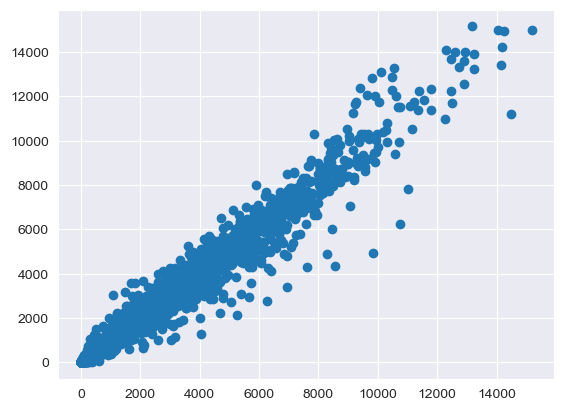

In [24]:
plt.scatter(np.expm1(y_val),np.expm1(y_pred_val))

In [25]:
model.feature_importance()

array([3819, 3135,  375,   56,   30,   42, 3029,   28,  711,   74,  635,
        646,  205,  994,  170,  183,  143,  201,  137,  457,  168,   89,
        131,  153,  261,  172,   91,   74,   67,  280,  880,  701,   71,
        360,  304,   57,  636,  336,   64, 1203,  508,  185])

In [26]:
model.feature_name()

['store_nbr',
 'family',
 'onpromotion',
 'cluster',
 'Holiday_type',
 'locale',
 'description',
 'transferred',
 'dcoilwtico',
 'month',
 'day_of_month',
 'day_of_year',
 'week_of_year',
 'day_of_week',
 'sales_lag_16',
 'sales_lag_17',
 'sales_lag_18',
 'sales_lag_19',
 'sales_lag_20',
 'sales_lag_21',
 'sales_lag_22',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_90',
 'sales_lag_180',
 'sales_lag_365',
 'sales_roll_mean_16',
 'sales_roll_mean_17',
 'sales_roll_mean_18',
 'sales_roll_mean_30',
 'sales_ewm_alpha_095_lag_1',
 'sales_ewm_alpha_095_lag_7',
 'sales_ewm_alpha_095_lag_30',
 'sales_ewm_alpha_09_lag_1',
 'sales_ewm_alpha_09_lag_7',
 'sales_ewm_alpha_09_lag_30',
 'sales_ewm_alpha_08_lag_1',
 'sales_ewm_alpha_08_lag_7',
 'sales_ewm_alpha_08_lag_30',
 'sales_ewm_alpha_05_lag_1',
 'sales_ewm_alpha_05_lag_7',
 'sales_ewm_alpha_05_lag_30']

## Submission

In [28]:
submission = pd.read_csv(r"C:\Users\derek.filko\DataspellProjects\Kaggle\Store Sales\data\sample_submission.csv")
y_test = model.predict(X_test, num_iteration=model.best_iteration)

In [29]:
y_test[y_test<0]=0

In [30]:
submission["sales"] = np.expm1(y_test)

In [31]:
submission.to_csv("submission.csv",index=False)

In [32]:
submission

,id,sales
0,3000888,4.198829
1,3000889,0.035366
2,3000890,5.583956
3,3000891,2495.038881
4,3000892,0.103274
...,...,...
28507,3029395,383.578335
28508,3029396,122.762627
28509,3029397,1783.622462
28510,3029398,140.766797
